In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import numpy as np


from source.exponenta import get_stat
from source.lin_exp import lin_exponenta, lin_exp
from source.net_bilstm import BiLSTMAutoencoder
from source.net_gru import Seq2Seq

Загружаем НС для дисконтирования данных к последнему дню 

In [3]:
input_dim = 2
hidden_dim = 128
num_layers = 1


model = BiLSTMAutoencoder(input_dim, hidden_dim, num_layers)
model.load_state_dict(torch.load('source/trend_bilstm_cpu',weights_only=False));

Тестовые данные

In [4]:
df = pd.read_csv('source/cloth_9611772.csv')
order = df.SaleQty.values
price = df.CurrentRetailPrice.values

Дисконт

In [5]:
p_norm = (price - price.min())/(price.max()-price.min())
# extract trend
X = torch.zeros(1,p_norm.size,2,dtype=torch.float32)

X[:,:,0] = torch.tensor(p_norm)
X[:,:,1] = torch.tensor(order)
output = model(X)
output = output.detach().numpy().squeeze()

output = output[-1]/output
discount_order = order*output

Выбор модели спроса: exponenta vs lin exponenta

In [16]:
# модель экспоненты
b = get_stat(p_norm,discount_order)
# lin_expo
a0,b0,c0,I,out = lin_exponenta(p_norm,discount_order)

if out*I:
    fun_lin = True
else:
    fun_lin = False

b = get_stat(p_norm,discount_order)

if fun_lin:
    o1 = lin_exp(p_norm,a0,b0,c0)  
    s1 = ((o1 - discount_order)**2).sum()
    o2 = np.exp(b[0]+b[1]*p_norm)
    s2 = ((o2 - discount_order)**2).sum()
    if s1 > s2:
        fun = lambda x: np.exp(b[0]+b[1]*x)
    else:
        fun = lambda x: lin_exp(x,a0,b0,c0)
else:
    fun = lambda x: np.exp(b[0]+b[1]*x)

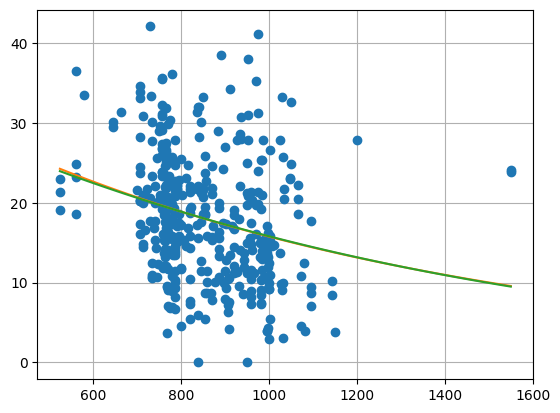

In [18]:
# ================================  plot =====================================
z = np.linspace(price.min(),price.max())
z_norm = np.linspace(0,1)
plt.plot(price,discount_order,'o')
plt.plot(z, np.exp(b[0]+b[1]*z_norm))
plt.plot(z,a0 * (z_norm- b0) * np.exp(-c0 * (z_norm - b0)))
plt.grid(True)

### Оптимальная цена  
Для оптимальной цены необходимо знать стоимость доставки, себистоимость товара и комиссию маркетплейса (это есть в данных)

In [25]:
num_day_predict = 1 # Количество дней предсказаний
model = torch.load('source/trend_gru_cpu',weights_only=False);

In [41]:
XX = X.permute([1,0,2])
out_predict = model(XX,num_step=num_day_predict).detach().numpy().squeeze()

()

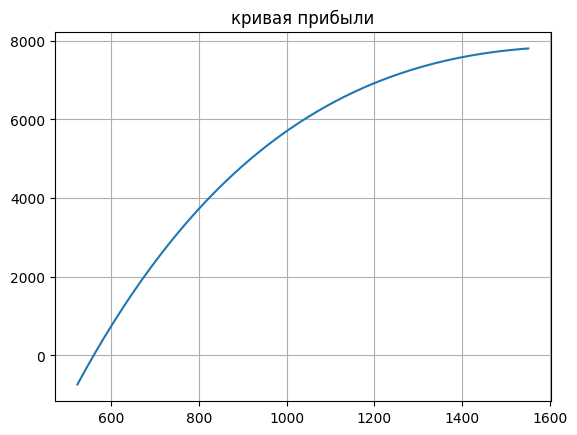

In [42]:
com_mp = 0.18 # комиссия маркетплейса 18%
self_price = 500 # себистоимость товара
delivery = 50 # доставка
x_norm = np.linspace(0,1)
x_grid = np.linspace(price.min(),price.max())
#plt.plot(p_norm,discount_order,'o')
#plt.plot(x_norm,fun(x_norm))
margin = ((x_grid - self_price)*fun(x_norm)*out_predict)*(1-com_mp) -  fun(x_norm)*out_predict*delivery# уточнить у Индипы
plt.plot(x_grid,margin)
plt.title('кривая прибыли')
plt.grid(True)

Максимум прибыли (это еще не бандит)

In [52]:
idx = np.argmax(margin)
max = x_grid[idx]
print('максимальная маржинальность: ',  ((x_grid[idx] - self_price)*fun(x_norm[idx])*out_predict)*(1-com_mp) -  fun(x_norm[idx])*out_predict*delivery ,'в точке цены ', max)

максимальная маржинальность:  7800.083179246779 в точке цены  1550.0


### Предсказания

In [55]:
num_day_predict = 14 # Количество дней предсказаний
#model = torch.load('source/trend_gru_cpu',weights_only=False);

In [56]:
# XX = X.permute([1,0,2])
out_predict = model(XX,num_step=num_day_predict).detach().numpy().squeeze(2)


s = price[-1]
price_range = price.max() - price.min()

one_per = price_range/100
t = np.arange(-25,25)
new_price = np.round(t*one_per +s )

norm_new_price = (new_price - price.min())/(price.max()-price.min())
out_grid = np.zeros((num_day_predict,new_price.size))
for i in range(num_day_predict):
    out_grid[i,:] = fun(norm_new_price)*out_predict[i]

Предсказания на 14 дней в заданных точках цены:

In [57]:
df = pd.DataFrame(out_grid)
df.columns = list((new_price))
df

,742.0,753.0,763.0,773.0,784.0,794.0,804.0,814.0,825.0,835.0,...,1153.0,1163.0,1173.0,1184.0,1194.0,1204.0,1214.0,1225.0,1235.0,1245.0
0,19.999286,19.800955,19.622362,19.445380,19.252543,19.078896,18.906816,18.736288,18.550482,18.383168,...,13.781359,13.657059,13.533880,13.399667,13.278809,13.159042,13.040356,12.911036,12.794586,12.679186
1,19.952123,19.754261,19.576089,19.399524,19.207142,19.033904,18.862230,18.692104,18.506736,18.339817,...,13.748859,13.624853,13.501965,13.368067,13.247495,13.128011,13.009604,12.880589,12.764414,12.649286
2,19.939686,19.741946,19.563886,19.387431,19.195168,19.022039,18.850472,18.680451,18.495200,18.328384,...,13.740289,13.616359,13.493548,13.359734,13.239237,13.119827,13.001494,12.872560,12.756457,12.641401
3,19.914250,19.716763,19.538929,19.362700,19.170682,18.997774,18.826425,18.656622,18.471607,18.305004,...,13.722761,13.598990,13.476335,13.342692,13.222349,13.103091,12.984909,12.856139,12.740184,12.625275
4,19.909170,19.711733,19.533945,19.357760,19.165792,18.992927,18.821622,18.651862,18.466894,18.300334,...,13.719260,13.595521,13.472897,13.339288,13.218976,13.099748,12.981596,12.852859,12.736934,12.622054
5,19.894312,19.697023,19.519367,19.343314,19.151489,18.978754,18.807577,18.637943,18.453113,18.286677,...,13.709022,13.585375,13.462843,13.329334,13.209111,13.089972,12.971909,12.843268,12.727429,12.612635
6,19.862484,19.665511,19.488139,19.312368,19.120850,18.948391,18.777487,18.608126,18.423591,18.257421,...,13.687090,13.563640,13.441304,13.308009,13.187978,13.069030,12.951155,12.822721,12.707067,12.592457
7,19.814310,19.617814,19.440873,19.265528,19.074474,18.902434,18.731945,18.562994,18.378907,18.213140,...,13.653893,13.530743,13.408704,13.275732,13.155992,13.037333,12.919744,12.791621,12.676248,12.561915
8,19.750958,19.555091,19.378715,19.203931,19.013488,18.841997,18.672054,18.503643,18.320145,18.154908,...,13.610238,13.487482,13.365833,13.233285,13.113929,12.995649,12.878436,12.750722,12.635718,12.521751
9,19.673329,19.478231,19.302549,19.128451,18.938757,18.767940,18.598664,18.430915,18.248138,18.083551,...,13.556744,13.434470,13.313299,13.181273,13.062386,12.944571,12.827818,12.700606,12.586054,12.472536
